In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
import os

In [2]:
# Define data transformations for data augmentation and normalization
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [3]:
# Define the data directory
data_dir = 'dataset'

# Create data loaders
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
#image_datasets

In [4]:
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=4) for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
print(dataset_sizes)

class_names = image_datasets['train'].classes
class_names

{'train': 3372, 'val': 845}


['cataract', 'diabetic_retinopathy', 'glaucoma', 'normal']

In [5]:
# Load the pre-trained ResNet-18 model
model = models.resnet18(pretrained=True)

# Freeze all layers except the final classification layer
for name, param in model.named_parameters():
    if "fc" in name:  # Unfreeze the final classification layer
        param.requires_grad = True
    else:
        param.requires_grad = False

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)  # Use all parameters


# Move the model to the GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)


c:\Users\tharu\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\tharu\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [6]:

# Training loop
num_epochs = 50
train_losses = []
val_losses = []
train_accs = []
val_accs = []

for epoch in range(num_epochs):
    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()
        else:
            model.eval()

        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in dataloaders[phase]:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects.double() / dataset_sizes[phase]

        if phase == 'train':
            train_losses.append(epoch_loss)
            train_accs.append(epoch_acc)
        else:
            val_losses.append(epoch_loss)
            val_accs.append(epoch_acc)

        print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

print("Training complete!")


train Loss: 1.3238 Acc: 0.5211
val Loss: 0.9001 Acc: 0.6320
train Loss: 1.0441 Acc: 0.5993
val Loss: 0.8779 Acc: 0.6615
train Loss: 1.0531 Acc: 0.5988
val Loss: 0.8262 Acc: 0.6722
train Loss: 1.0802 Acc: 0.5833
val Loss: 0.8532 Acc: 0.6769
train Loss: 1.0621 Acc: 0.5970
val Loss: 0.6249 Acc: 0.7456
train Loss: 1.0136 Acc: 0.6165
val Loss: 0.8241 Acc: 0.6852
train Loss: 1.0125 Acc: 0.6278
val Loss: 0.6781 Acc: 0.7456
train Loss: 1.0600 Acc: 0.5943
val Loss: 0.7206 Acc: 0.7361
train Loss: 1.0550 Acc: 0.5976
val Loss: 0.7609 Acc: 0.7243
train Loss: 1.0021 Acc: 0.6192
val Loss: 0.6929 Acc: 0.7420
train Loss: 1.0520 Acc: 0.6014
val Loss: 0.9146 Acc: 0.6604
train Loss: 1.0200 Acc: 0.6127
val Loss: 0.9668 Acc: 0.6639
train Loss: 1.0158 Acc: 0.6186
val Loss: 0.5963 Acc: 0.7704
train Loss: 1.0250 Acc: 0.6112
val Loss: 0.6721 Acc: 0.7373
train Loss: 1.0478 Acc: 0.6091
val Loss: 0.8876 Acc: 0.7065
train Loss: 1.0261 Acc: 0.6145
val Loss: 0.5811 Acc: 0.7669
train Loss: 1.0455 Acc: 0.6151
val Loss:

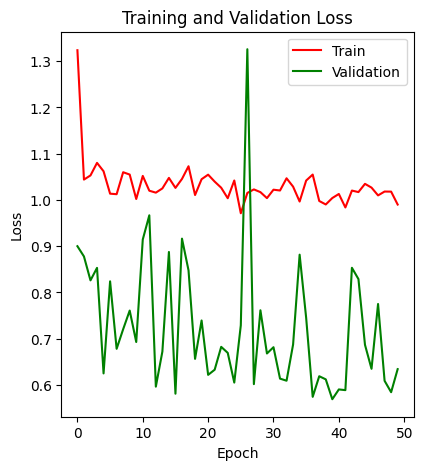

In [7]:
# Plotting
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train',color='red')
plt.plot(val_losses, label='Validation',color='green')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

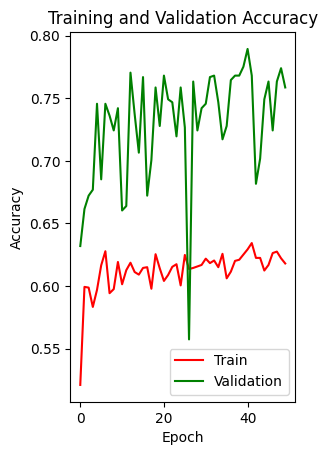

In [8]:
import matplotlib.pyplot as plt

import torch

# Convert lists to tensors
train_accs_tensor = torch.tensor(train_accs)
val_accs_tensor = torch.tensor(val_accs)

plt.subplot(1, 2, 2)
plt.plot(train_accs_tensor.cpu(), label='Train',color='red')  # Convert to tensor and move to CPU
plt.plot(val_accs_tensor.cpu(), label='Validation',color='green')  # Convert to tensor and move to CPU
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()


In [9]:

# Save the model
torch.save(model.state_dict(), 'eye_disease_model1.pth')


c:\Users\tharu\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\tharu\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


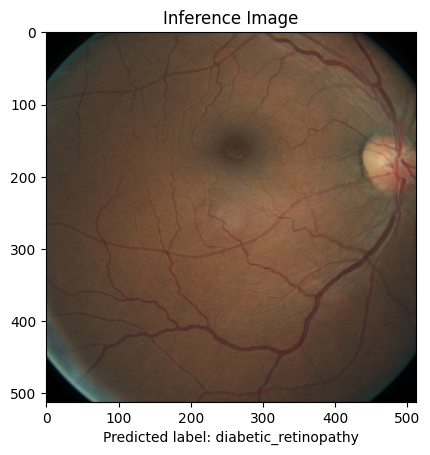

In [10]:
import torch
from torchvision import transforms
from PIL import Image

# Define the transformation for inference
inference_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load the imageE:\Eye_disease\dataset1\cataract\_1_5346540.jpg
image_path = r'E:\Eye_disease\dataset\val\diabetic_retinopathy\1024_left.jpeg'  # Replace 'path/to/your/image.jpg' with the path to your image
image = Image.open(image_path)

# Apply the transformation
input_image = inference_transform(image)
input_image = input_image.unsqueeze(0)  # Add a batch dimension

# Move the input to the GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
input_image = input_image.to(device)

# Load the model
model = models.resnet18(pretrained=False)  # Assuming you're loading the same model architecture
model.load_state_dict(torch.load('eye_disease_model1.pth'))  # Load the saved model state
model = model.to(device)
model.eval()

# Perform inference
with torch.no_grad():
    output = model(input_image)
    probabilities = torch.nn.functional.softmax(output[0], dim=0)
    predicted_class_index = torch.argmax(probabilities).item()
    predicted_class = class_names[predicted_class_index]
plt.imshow(image)
plt.title("Inference Image")
plt.xlabel("Predicted label: " + predicted_class)
plt.show()
